In [2]:
import numpy as np
from numba import jit, float64
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# vectorized Runge Kutta 4th order solver

In [38]:
def step_RK4(Y, dt, homogeneous_dYdt):
    ''' Perform 1 step using Runge Kutta 4th order integrator
    Y:  nd array of shape (number of dim, numbers of points)
    '''
   
    k1 = homogeneous_dYdt(Y)
    k2 = homogeneous_dYdt(Y + dt/2*k1)
    k3 = homogeneous_dYdt(Y + dt/2*k2)
    k4 = homogeneous_dYdt(Y + dt*k3)

    Ynext = Y + dt/6*(k1 + 2*k2 + 2*k3 + k4)
    
    return Ynext

In [36]:
@jit(float64[:, :](float64[:, :], float64), nopython=True)
def thomas_attractor_2d_normed(xyz, b):
    ''' ODE for Thomas attractor
        xyz: point positions, shape (dim, )
    '''
    sin_xyz = np.sin(xyz)
    dYdt = -b*xyz
    dYdt[0, :] += sin_xyz[1, :]
    dYdt[1, :] += sin_xyz[2, :]
    dYdt[2, :] += sin_xyz[0, :]
    dYdt /= np.sqrt( np.sum(dYdt**2, axis=0) )
    return dYdt

xyz = np.random.rand(3, 1)
_ = thomas_attractor_2d_normed(xyz, 0.21)

In [32]:
xyz = np.random.rand(3, 500)

In [33]:
%%timeit
_ = thomas_attractor_2d_normed(xyz, 0.21)

22.5 µs ± 77.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [48]:
b = 0.198
xyz = np.random.rand(3, 10)

def dYdt(y):
    return thomas_attractor_2d_normed(y, b)

In [49]:
%%timeit
_ = dYdt(xyz)

1.58 µs ± 13.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [47]:
%%timeit
_ = step_RK4(xyz, 0.01, dYdt)

# 15.7 µs ± 77.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

15.3 µs ± 140 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [53]:
n = 10000000
np.sum(np.ones(n)/n)

1.0000000000000173

In [23]:
def thomas_attractor(xyz, b=0.19):
    # xyz shape (dim x nbr points)
    sin_xyz = np.sin(xyz)
    dYdt = -b*np.copy(xyz)
    dYdt[0, :] += sin_xyz[1, :]
    dYdt[1, :] += sin_xyz[2, :]
    dYdt[2, :] += sin_xyz[0, :]
    return dYdt

In [25]:
%%timeit
_ = thomas_attractor(Y, b=0.19)
# 20.5 µs ± 122 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
# 16.2 µs ± 139 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

16.5 µs ± 122 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [67]:
Y = np.random.randn(3, n_points)

In [72]:
import itertools as it

In [90]:
b_str_list = [ f'{a}{b}{c}' for a, b, c in it.product([1, ], range(10), [2, 8])]
print(b_str_list)

['102', '108', '112', '118', '122', '128', '132', '138', '142', '148', '152', '158', '162', '168', '172', '178', '182', '188', '192', '198']


## Change b

0.102
0.108
0.112
0.118
0.122
0.128
0.132
0.138
0.142
0.148
0.152
0.158
0.162
0.168
0.172
0.178
0.182
0.188
0.192
0.198


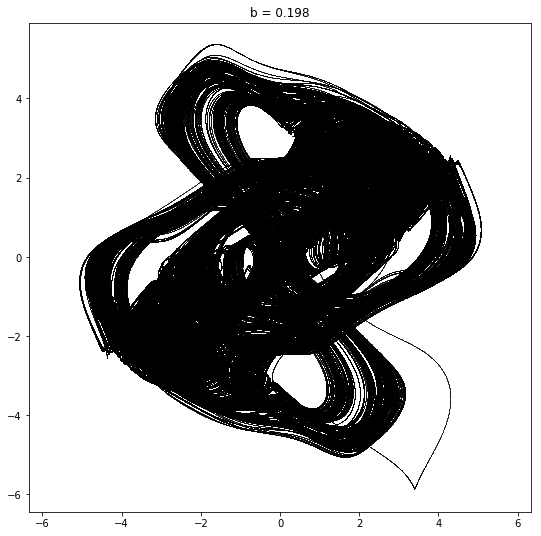

In [91]:
plt.figure(figsize=(9, 9))
for b_str in b_str_list:
    
    b = float(b_str)/1000
    n_points = 30
    Y = np.random.rand(3, n_points)*0.1 + 1

    t, dt = 0, 0.01


    def dYdt(t, Y):
        return thomas_attractor(Y, b=b)

    # burn
    for _ in range(10000):
        t, Y = step_RK4(dt, t, Y, dYdt)

    store_Y = []
    for k in range(10000):
        t, Y = step_RK4(dt, t, Y, dYdt)
        store_Y.append(Y)

    store_Y = np.array(store_Y)

    step = 1
    plt.plot(store_Y[::step, 0, :], store_Y[::step, 1, :], ',',
             linewidth=1, color='black', alpha=0.7);
    plt.axis('equal');
    plt.title(f'b = {b}');
    plt.savefig(f'figs/rand_postif_thomas_b{b_str}.png')
    print(b)

# Animation

In [104]:
b = 0.19
n_points = 1000

Y = np.random.rand(3, n_points)*12 - 6 

t, dt = 0, 0.01

def dYdt(t, Y):
    return thomas_attractor(Y, b=b)

# burn
for _ in range(5000):
    t, Y = step_RK4(dt, t, Y, dYdt)

In [105]:
import matplotlib.animation as animation

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899

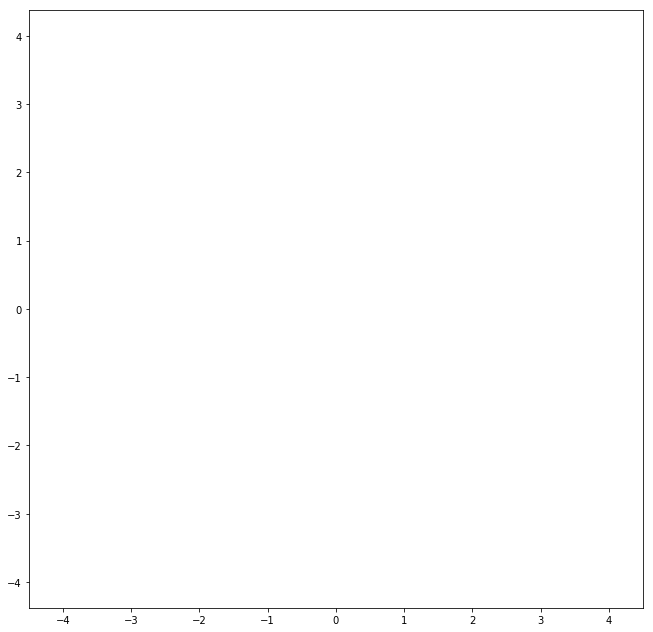

In [115]:
fig = plt.figure(figsize=(11, 11))
frames = []
n_fig = 100
for k in range(n_fig):
    print(k, end='\r')
    store_Y = []
    for _ in range(100):
        t, Y = step_RK4(dt, t, Y, dYdt)
        store_Y.append(Y)

    store_Y = np.array(store_Y)

    Y = store_Y[25, :, :]
    
    step = 1
    
    f = plt.plot(store_Y[::step, 0, :], store_Y[::step, 1, :], ',',
             linewidth=1, color='black', alpha=0.7);
    frames.append(f)
    plt.axis('equal');
    #plt.title(f'b = {b}');
    #plt.savefig(f'anim/thomas_k{k}.png')
ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True,
                                repeat_delay=100);

In [116]:
ani.save('dynamic_images.gif', writer='imagemagick')

## without matplotlib

In [181]:
import imageio

In [234]:
b = 0.19
n_points = 1000

Y = np.random.rand(3, n_points)*12 - 6 

t, dt = 0, 0.01

def dYdt(t, Y):
    return thomas_attractor(Y, b=b)

# burn
for _ in range(5000):
    t, Y = step_RK4(dt, t, Y, dYdt)

In [235]:
half_attractor_size = 4.2  # demi axe
nbr_pixel = 600

image = np.zeros((nbr_pixel, nbr_pixel))

In [208]:
# accumulate pixel value
store_Y = []
for _ in range(100):
    t, Y = step_RK4(dt, t, Y, dYdt)
    Y_px = np.rint( (Y + half_attractor_size)/(2*half_attractor_size) * nbr_pixel ).astype(int)
    z_scale = (Y_px[2, :]/nbr_pixel)**2  # shade function of Z
    np.add.at(image, (Y_px[0, :], Y_px[1, :]), z_scale)
    # see https://stackoverflow.com/a/28894452/8069403

In [209]:
I_save = np.copy(image)

In [210]:
image = I_save

In [211]:
image = image / image.max()
image = 255 * np.sqrt((image))
image = image.astype(np.uint8)

imageio.imwrite('image_name.png', image)

![hello](./image_name.png)

In [135]:
Y_px = np.rint( (Y + half_attractor_size)/(2*half_attractor_size) * nbr_pixel ).astype(int)

### Animation without matplotlib

In [251]:
b = 0.19
n_points = 1500

Y = np.random.rand(3, n_points)*12 - 6 

t, dt = 0, 0.01

def dYdt(t, Y):
    return thomas_attractor(Y, b=b)

# burn
for _ in range(5000):
    t, Y = step_RK4(dt, t, Y, dYdt)

In [252]:
half_attractor_size = 4.2  # demi axe
nbr_pixel = 650

image = np.zeros((nbr_pixel, nbr_pixel))

In [253]:
n_fig = 150

for k in range(n_fig):
    image = np.zeros((nbr_pixel, nbr_pixel))
    for i in range(100):
        t, Y = step_RK4(dt, t, Y, dYdt)
        
        Y_px = np.rint( (Y + half_attractor_size)/(2*half_attractor_size) * nbr_pixel ).astype(int)
        #np.add.at(image, (Y_px[0, :], Y_px[1, :]), z_scale)
        z_scale = 0.6*(Y_px[2, :]/nbr_pixel)**2 + 0.4 # shade function of Z
        image[Y_px[0, :], Y_px[1, :]] = z_scale

        # starting point for the next frame
        if i == 25:
            Y_next = np.copy(Y)
    
    Y = Y_next
    
    image = image / image.max()
    image = 255 * (1 - image)
    image = image.astype(np.uint8)

    imageio.imwrite(f'anim/image_{k:04d}.png', image)
    print(k, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 

ImageMagick 
    
    convert -delay 10   -loop 0   image_*.png  animated_attractor.gif


In [249]:
f'hello{1:04d}'

'hello0001'